# Problem Statement and Business Understanding.

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

 

After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 

 

And this is where you come in as a data analyst. Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

##### submitted by: Solon Kumar Das

# 1. Importing the necessary packages.

In [1]:
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn

# for scaling.
from sklearn.preprocessing import StandardScaler

# for K-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# for hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# for principal component analysis
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Reading and Understanding the data.

In [2]:
country = pd.read_csv('Country-data.csv')
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# lets check the shape of the data.
country.shape

(167, 10)

In [4]:
# lets check the missing values
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [5]:
# basic missing value check.
country.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Conclusion: There are no missing values present in the dataset.

In [6]:
country.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


Let's convert imports,exports and health spending from  percentage values to actual values of their GDP per capita
.Because the percentage values don't give a clear picture of that country. 
For ex. afghanistan and albania have similar imports percentange but their gdpp has a huge gap which doesn't give an accurate idea of which country is more developed than the other.

In [7]:
# Converting exports,imports and health spending percentages to absolute values.

country['exports'] = country['exports']*country['gdpp']/100
country['imports'] = country['imports']*country['gdpp']/100
country['health'] = country['health']*country['gdpp']/100
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


# 3. Data Preparation.

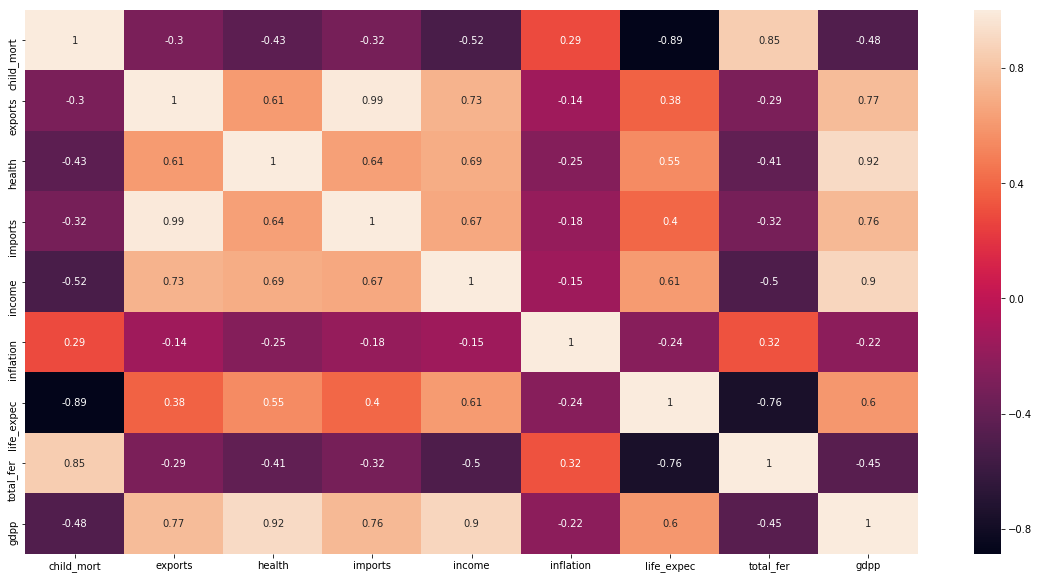

In [8]:
'''

- This data seems largely clean,but we have a lot of variables and making and 
  visualising proper clusters will be a difficulty.
- Let's see if we can apply PCA to do dimensional reduction.
- First let's plot the correlation matrix and check if the data is indeed highly correlated
  so that the usage of PCA in this scenario is justified.
  
'''
plt.figure(figsize = (20,10))        
sns.heatmap(country.corr(),annot = True)

We indeed see some correlation among the columns so lets do PCA and omit the correlation.

### Scaling and preparing the data for PCA

In [9]:
# preparing the data before PCA.

In [10]:
# separating the nuemerical variables from the catagorical label country.
y = country['country']

In [11]:
# Now our dataset will only contain nuemerical columns..
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [12]:
# scaling the data..

# Creating a scaler object
scaler = StandardScaler()
# creating a copy of dataset into a new dataframe.
X = country.drop('country',1)
# fitting and transforming the scaler object
x = scaler.fit_transform(X)

# 4. Performing Principle Component Analysis (PCA)

In [13]:
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [14]:
# Lets see each component that is created by the PCA.
pca.components_

array([[-0.31639186,  0.34288671,  0.358535  ,  0.34486492,  0.38004113,
        -0.14308531,  0.34385651, -0.30284224,  0.39998795],
       [ 0.47626735,  0.39731091,  0.1550529 ,  0.37078075,  0.12838448,
         0.22126089, -0.36981973,  0.4597152 ,  0.2006241 ],
       [-0.15001225, -0.03057367, -0.07570322, -0.07217386,  0.14576421,
         0.94841868,  0.19675173, -0.07783431,  0.01033941],
       [-0.14805195,  0.44942527, -0.59971228,  0.46179779, -0.15480592,
        -0.00762798, -0.01839465, -0.21392805, -0.36477239],
       [ 0.1019948 , -0.03853829, -0.49319984, -0.2527867 ,  0.79407469,
        -0.13642345, -0.15404105, -0.02033568,  0.08750149],
       [ 0.19658519, -0.03891112,  0.18069888, -0.01217988, -0.03814681,
         0.10840284, -0.58600986, -0.75390075,  0.04538167],
       [ 0.76126725, -0.01366973, -0.06461567,  0.02718244, -0.02311312,
        -0.02207663,  0.58120846, -0.27314534, -0.04402264],
       [ 0.00644411, -0.05526371,  0.43007213,  0.1311355 ,  0

In [15]:
# lets see the variance ratio of each component and check the variance that each component explains.
pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

### Making the Scree Plot

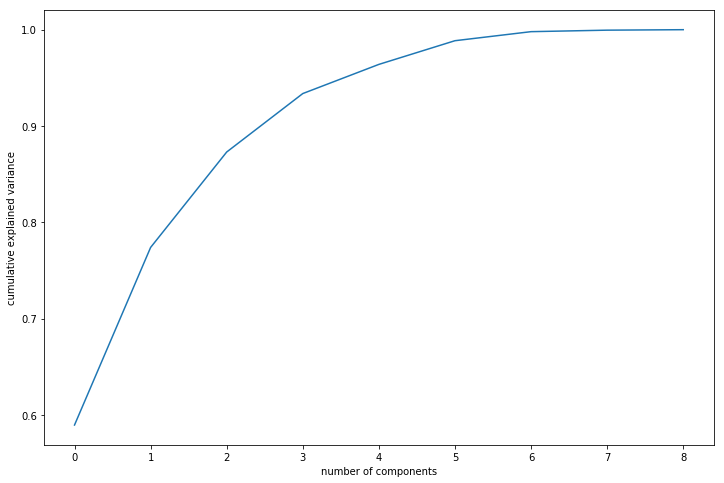

In [16]:
# constructing the scree plot.
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Conlusion: Clearly over 90% of the data is properly explained by the first 3 principal components. Let's use them only for our clustering process

In [17]:
# Let's try and check the first three components now

colnames = list(country.drop('country',axis=1).columns)
pc_df = pd.DataFrame({ 'Feature':colnames,'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2]})
pc_df

,Feature,PC1,PC2,PC3
0,child_mort,-0.316392,0.476267,-0.150012
1,exports,0.342887,0.397311,-0.030574
2,health,0.358535,0.155053,-0.075703
3,imports,0.344865,0.370781,-0.072174
4,income,0.380041,0.128384,0.145764
5,inflation,-0.143085,0.221261,0.948419
6,life_expec,0.343857,-0.369820,0.196752
7,total_fer,-0.302842,0.459715,-0.077834
8,gdpp,0.399988,0.200624,0.010339


In [18]:
# We are observing 90% variance with 3 principal components. So let's take the data until that many components
# Using incremental PCA for efficiency - saves a lot of time on larger datasets

pca_final = IncrementalPCA(n_components=3)

In [19]:
# let's project our original data on the 3 principal components

df_train_pca = pca_final.fit_transform(x)
df_train_pca.shape

(167, 3)

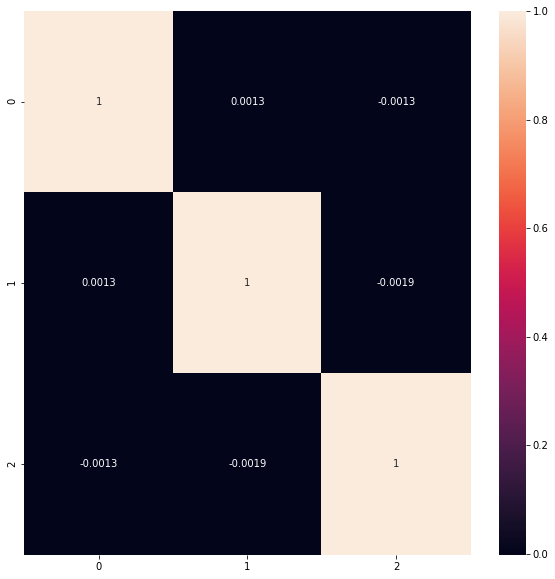

In [20]:
# lets have a look at the correlation map after PCA.
corrmat = np.corrcoef(df_train_pca.transpose())
plt.figure(figsize=[10,10])
sns.heatmap(corrmat, annot=True)

Conclusion : we see that our principal components are completely uncorelated. 

In [21]:
# take the transpose of the PC matrix so that we can create the new matrix

pc = np.transpose(df_train_pca)

In [22]:
# Let's create the newer matrix according to the given principal components

rownames = list(country['country'])
pcs_df2 = pd.DataFrame({'country':rownames,'PC1':pc[0],'PC2':pc[1],'PC3':pc[2]})
pcs_df2.head()

,country,PC1,PC2,PC3
0,Afghanistan,-2.637442,1.469038,-0.541359
1,Albania,-0.022277,-1.431896,-0.020701
2,Algeria,-0.457626,-0.673301,0.961867
3,Angola,-2.724520,2.174583,0.606687
4,Antigua and Barbuda,0.649849,-1.024374,-0.250103


# 5. Outlier Analysis and treatment

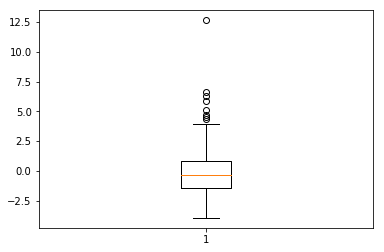

In [23]:
# Let's do the outlier analysis before proceeding to clustering
# We can reassign the outliers to the clusters later

plt.boxplot(pcs_df2.PC1)
Q1 = pcs_df2.PC1.quantile(0.05)
Q3 = pcs_df2.PC1.quantile(0.95)
IQR = Q3 - Q1
pcs_df2 = pcs_df2[(pcs_df2.PC1 >= Q1) & (pcs_df2.PC1 <= Q3)]

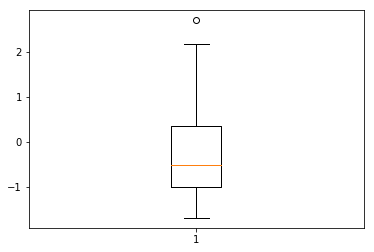

In [24]:
plt.boxplot(pcs_df2.PC2)
Q1 = pcs_df2.PC2.quantile(0.05)
Q3 = pcs_df2.PC2.quantile(0.95)
IQR = Q3 - Q1
pcs_df2 = pcs_df2[(pcs_df2.PC2 >= Q1) & (pcs_df2.PC2 <= Q3)]

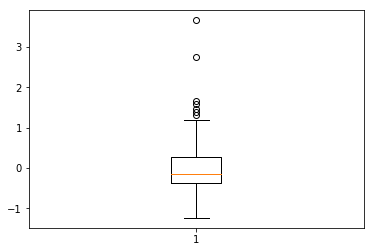

In [25]:
plt.boxplot(pcs_df2.PC3)
Q1 = pcs_df2.PC3.quantile(0.05)
Q3 = pcs_df2.PC3.quantile(0.95)
IQR = Q3 - Q1
dat3 = pcs_df2[(pcs_df2.PC3 >= Q1 ) & (pcs_df2.PC3 <= Q3)]

In [26]:
# Outlier analysis is now done.Let's check the data again.
pcs_df2.shape

(133, 4)

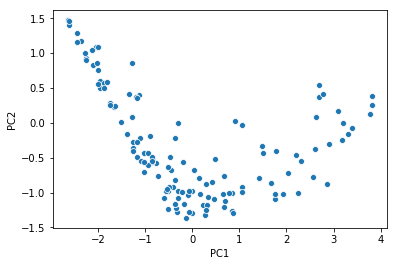

In [27]:
# let's check the spread of the dataset
sns.scatterplot(x='PC1',y='PC2',data=pcs_df2)

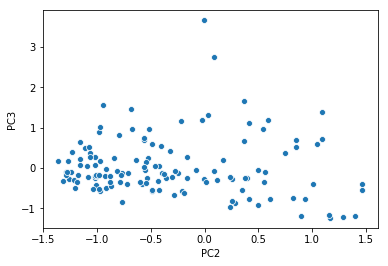

In [28]:
sns.scatterplot(x='PC2',y='PC3',data=pcs_df2)

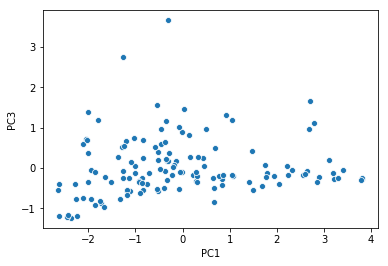

In [29]:
sns.scatterplot(x='PC1',y='PC3',data=pcs_df2)

# 6. Clustering

### K-means clustering.

In [30]:
# lets scale the data again.
dat3 = pcs_df2
dat3_1 = scaler.fit_transform(dat3.drop(['country'],axis=1))

In [31]:
# Let's check the silhouette score first to identify the ideal number of clusters

from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(dat3_1)
    sse_.append([k, silhouette_score(dat3_1, kmeans.labels_)])

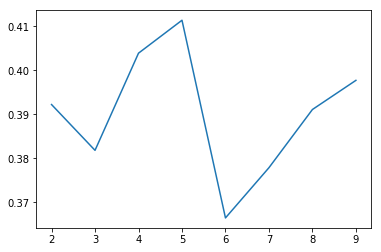

In [32]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

The sihouette score reaches a peak at around 5 clusters indicating that it might be the ideal number of clusters.

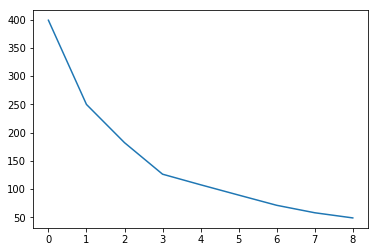

In [33]:
# Let's use the elbow curve method to identify the ideal number of clusters.

ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(random_state= 42, n_clusters = num_clusters, max_iter=50)
    model_clus.fit(dat3_1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

A distinct elbow is formed at around 3-7 clusters. Let's finally create the clusters and see for ourselves which ones fare better


In [34]:
# K-means with k=5 clusters

model_clus5 = KMeans(random_state= 42, n_clusters = 5, max_iter=50)
model_clus5.fit(dat3_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [35]:
dat4=dat3
dat4.index = pd.RangeIndex(len(dat4.index))
dat_km = pd.concat([dat4, pd.Series(model_clus5.labels_)], axis=1)
dat_km.columns = ['country', 'PC1', 'PC2','PC3','ClusterID']
dat_km.head()

,country,PC1,PC2,PC3,ClusterID
0,Afghanistan,-2.637442,1.469038,-0.541359,1
1,Algeria,-0.457626,-0.673301,0.961867,2
2,Antigua and Barbuda,0.649849,-1.024374,-0.250103,0
3,Argentina,0.037197,-0.680889,1.466963,2
4,Armenia,-0.332692,-1.274517,0.176636,0


In [36]:
dat_km['ClusterID'].value_counts()

0    63
3    25
1    18
4    14
2    13
Name: ClusterID, dtype: int64

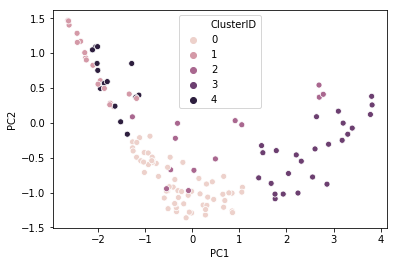

In [37]:
# Each cluster has a good number of countries associated with it(at least 5% of the dataset under consideration)
# Let's do some further visualizations.
# We'll be visualising the clusters on the original principal components
sns.scatterplot(x='PC1',y='PC2',hue='ClusterID',legend='full',data=dat_km)

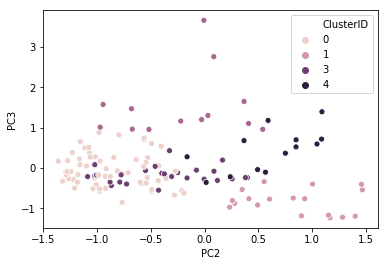

In [38]:
sns.scatterplot(x='PC2',y='PC3',hue='ClusterID',data=dat_km)

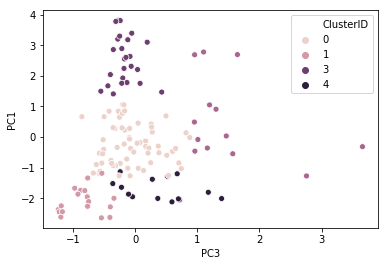

In [39]:
sns.scatterplot(x='PC3',y='PC1',hue='ClusterID',data=dat_km)

In [40]:
# One thing we noticed is some even though some distinct clusters are being formed, some are not so good.
# Now let's create the cluster means wrt to the various variables mentioned in the question and plot and see how they are related

dat5=pd.merge(country,dat_km,on='country')
dat6=dat5[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','ClusterID']]
clu_chi  =   pd.DataFrame(dat6.groupby(["ClusterID"]).child_mort.mean())
clu_exp  =   pd.DataFrame(dat6.groupby(["ClusterID"]).exports.mean())
clu_imp  =   pd.DataFrame(dat6.groupby(["ClusterID"]).imports.mean())
clu_hea  =   pd.DataFrame(dat6.groupby(["ClusterID"]).health.mean())
clu_inc  =   pd.DataFrame(dat6.groupby(["ClusterID"]).income.mean())
clu_inf  =   pd.DataFrame(dat6.groupby(["ClusterID"]).inflation.mean())         
clu_lif  =   pd.DataFrame(dat6.groupby(["ClusterID"]).life_expec.mean())
clu_tot  =   pd.DataFrame(dat6.groupby(["ClusterID"]).total_fer.mean())
clu_gdpp =   pd.DataFrame(dat6.groupby(["ClusterID"]).gdpp.mean())

df = pd.concat([pd.Series([0,1,2,3,4]),clu_chi,clu_exp,clu_imp,clu_hea,clu_inc,clu_inf,clu_lif,clu_tot,clu_gdpp], axis=1)
df.columns = ["ClusterID", "Child_Mortality", "Exports", "Imports","Health_Spending","Income","Inflation","Life_Expectancy","Total_Fertility","GDPpcapita"]
df

,ClusterID,Child_Mortality,Exports,Imports,Health_Spending,Income,Inflation,Life_Expectancy,Total_Fertility,GDPpcapita
0,0,23.538095,2629.653437,2877.322430,376.250603,10859.682540,5.808905,72.346032,2.322857,5830.857143
1,1,80.616667,400.130500,625.700222,105.735689,2670.000000,4.488611,59.455556,4.730000,1371.333333
2,2,16.223077,9365.739231,5763.193846,599.447615,33505.384615,20.592308,74.638462,2.393846,16063.076923
3,3,4.972000,13549.368000,13383.932000,3417.322400,34832.000000,1.432920,79.972000,1.726000,34532.000000
4,4,63.671429,1070.977129,953.021714,152.232614,5445.714286,15.645000,64.642857,4.347143,2566.428571


We observe that Child mortality, Income, Inflation and GDP per capita are good predictors for the development of a country. On cross-checking with the original Principal components that we drew, these 4 components had good scores. Hence we can say that they are a good source of information for the Clustering Process.Let's visualise the clusters along these.

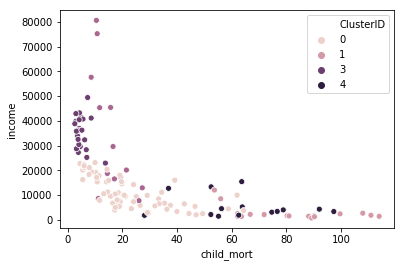

In [41]:
# Along child-mortality and income
sns.scatterplot(x='child_mort',y='income',hue='ClusterID',data=dat6)

In [42]:
# let's take a look at the best country cluster and try to make sense if the clustering process worked well.
dat6[dat6['ClusterID']==3]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
5,Australia,4.8,10276.2,10847.1,4530.87,41400,1.160,82.0,1.93,51900,3
6,Austria,4.3,24059.7,22418.2,5159.00,43200,0.873,80.5,1.44,46900,3
8,Bahamas,13.8,9800.0,12236.0,2209.20,22900,-0.393,73.8,1.86,28000,3
9,Bahrain,8.6,14386.5,10536.3,1028.79,41100,7.440,76.0,2.16,20700,3
23,Canada,5.6,13793.4,14694.0,5356.20,40700,2.870,81.3,1.63,47400,3
31,Cyprus,3.6,15461.6,17710.0,1838.76,33900,2.010,79.9,1.42,30800,3
32,Czech Republic,3.4,13068.0,12454.2,1560.24,28300,-1.430,77.5,1.51,19800,3
40,Finland,3.0,17879.4,17278.8,4134.90,39800,0.351,80.0,1.87,46200,3
41,France,4.2,10880.8,11408.6,4831.40,36900,1.050,81.4,2.03,40600,3
45,Germany,4.2,17681.4,15507.8,4848.80,40400,0.758,80.1,1.39,41800,3


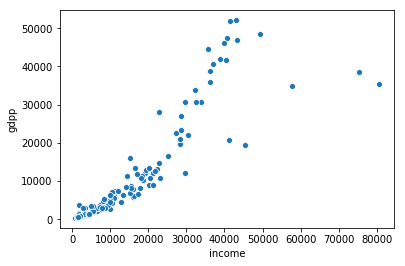

In [43]:
# K-means has done a satisfactory job here. Let's take a different approach and make the clusters only on the basis of these
sns.scatterplot(x='income',y='gdpp',data=dat6)

###  From the clusters it is observed that cluster 1 and 4 have pretty low values of the 4 indicators that we chose. Hence these are the countries that we need to focus.

In [44]:
dat6[dat6['ClusterID']==1]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,55.300,248.297,41.9174,1610,9.440,56.2,5.82,553,1
14,Benin,111.0,180.404,281.976,31.0780,1820,0.885,61.8,5.36,758,1
22,Cameroon,108.0,290.820,353.700,67.2030,2660,1.910,57.3,5.11,1310,1
28,Comoros,88.2,126.885,397.573,34.6819,1410,3.870,65.9,4.75,769,1
43,Gambia,80.3,133.756,239.974,31.9778,1660,4.300,65.5,5.71,562,1
50,Guinea-Bissau,114.0,81.503,192.544,46.4950,1390,2.970,55.6,5.05,547,1
64,Kenya,62.2,200.169,324.912,45.9325,2480,2.090,62.8,4.37,967,1
65,Kiribati,62.7,198.170,1190.510,168.3700,1730,1.520,60.7,3.84,1490,1
70,Lesotho,99.7,460.980,1181.700,129.8700,2380,4.150,46.5,3.30,1170,1
71,Liberia,89.3,62.457,302.802,38.5860,700,5.470,60.8,5.02,327,1


In [45]:
dat6[dat6['ClusterID']==4]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
17,Botswana,52.5,2768.6000,3257.550,527.0500,13300,8.92,57.1,2.88,6350,4
29,"Congo, Rep.",63.9,2331.7400,1498.780,67.4040,5190,20.70,60.4,4.95,2740,4
37,Eritrea,55.2,23.0878,112.306,12.8212,1420,11.60,61.7,4.61,482,4
42,Gabon,63.7,5048.7500,1653.750,306.2500,15400,16.60,62.9,4.08,8750,4
46,Ghana,74.7,386.4500,601.290,68.3820,3060,16.60,62.2,4.27,1310,4
57,Iraq,36.9,1773.0000,1534.500,378.4500,12700,16.60,67.2,4.56,4500,4
68,Lao,78.9,403.5600,562.020,50.9580,3980,9.20,63.8,3.15,1140,4
78,Mauritania,97.4,608.4000,734.400,52.9200,3320,18.90,68.2,4.98,1200,4
89,Pakistan,92.1,140.4000,201.760,22.8800,4280,10.90,65.3,3.85,1040,4
105,Solomon Islands,28.1,635.9700,1047.480,110.2950,1780,6.81,61.7,4.24,1290,4


### Hierarchical Clustering

##### Single Linkage

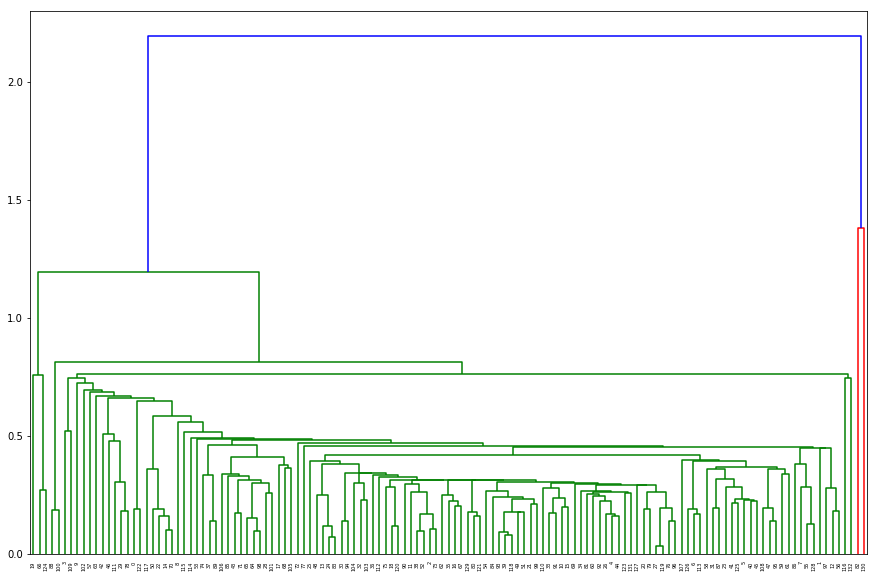

In [65]:
# First we'll try the single linkage procedure.

plt.figure(figsize=(15,10))
mergings = linkage(dat3_1, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

##### Complete Linkage

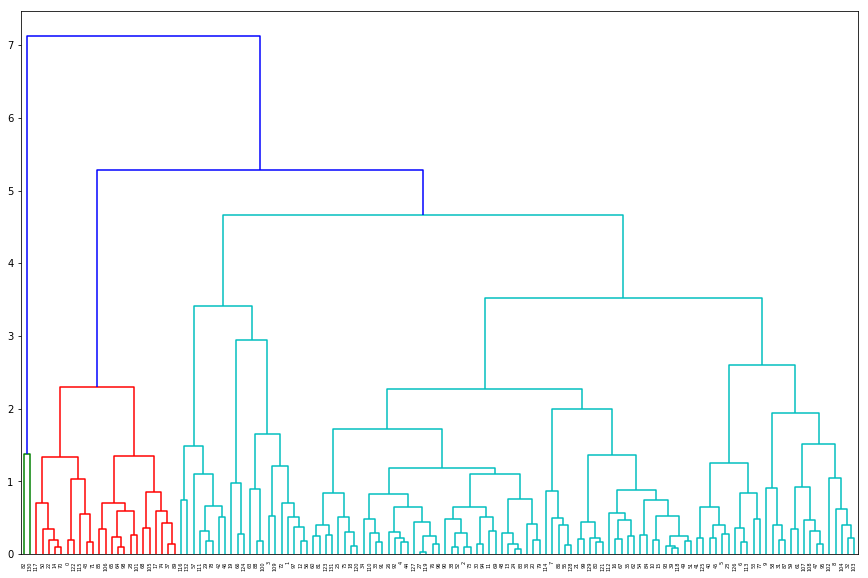

In [47]:
# We don't get good results in single linkage
# Let's try complete linkage method

plt.figure(figsize=(15,10))
mergings = linkage(dat3_1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [48]:
# Okay now we are seeing some good clusters here. Let's see if they make sense if we eliminate the barriers

clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
dat3_hc = pd.concat([dat3, clusterCut], axis=1)
dat3_hc.columns = ['country', 'PC1', 'PC2','PC3','ClusterID']

In [49]:
dat3_hc.head()

,country,PC1,PC2,PC3,ClusterID
0,Afghanistan,-2.637442,1.469038,-0.541359,0
1,Algeria,-0.457626,-0.673301,0.961867,1
2,Antigua and Barbuda,0.649849,-1.024374,-0.250103,2
3,Argentina,0.037197,-0.680889,1.466963,1
4,Armenia,-0.332692,-1.274517,0.176636,2


In [50]:
dat7=pd.merge(country,dat3_hc,on='country')
dat8=dat7[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','ClusterID']]
dat8.head()

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,55.30,248.297,41.9174,1610,9.44,56.2,5.82,553,0
1,Algeria,27.3,1712.64,1400.440,185.9820,12900,16.10,76.5,2.89,4460,1
2,Antigua and Barbuda,10.3,5551.00,7185.800,735.6600,19100,1.44,76.8,2.13,12200,2
3,Argentina,14.5,1946.70,1648.000,834.3000,18700,20.90,75.8,2.37,10300,1
4,Armenia,18.1,669.76,1458.660,141.6800,6700,7.77,73.3,1.69,3220,2


In [51]:
dat8['ClusterID'].value_counts()

2    61
3    26
0    23
1    21
4     2
Name: ClusterID, dtype: int64

In [52]:
# Cluster 4 doesn't have enough amount of clusters. Let's see if other clusters are good or not.

dat8[dat8['ClusterID']==2]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
2,Antigua and Barbuda,10.3,5551.00000,7185.800000,735.6600,19100,1.440,76.8,2.13,12200,2
4,Armenia,18.1,669.76000,1458.660000,141.6800,6700,7.770,73.3,1.69,3220,2
7,Azerbaijan,39.2,3171.12000,1208.880000,343.3920,16000,13.800,69.1,1.92,5840,2
10,Bangladesh,49.4,121.28000,165.244000,26.6816,2440,7.140,70.4,2.33,758,2
11,Barbados,14.2,6320.00000,7792.000000,1275.2000,15300,0.321,76.7,1.78,16000,2
13,Belize,18.8,2525.88000,2495.500000,225.6800,7880,1.140,71.4,2.71,4340,2
15,Bhutan,42.7,926.50000,1541.260000,113.3600,6420,5.990,72.1,2.38,2180,2
16,Bolivia,46.6,815.76000,679.140000,95.8320,5410,8.780,71.6,3.20,1980,2
18,Brazil,19.8,1198.40000,1321.600000,1009.1200,14500,8.410,74.2,1.80,11200,2
20,Bulgaria,10.8,3433.68000,3625.200000,469.9080,15300,1.110,73.9,1.57,6840,2


In [53]:
# this would be the cluster that we need to focus on as our best cluster.

dat8[dat8['ClusterID']==3]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
5,Australia,4.8,10276.2,10847.1,4530.87,41400,1.160,82.0,1.93,51900,3
6,Austria,4.3,24059.7,22418.2,5159.00,43200,0.873,80.5,1.44,46900,3
8,Bahamas,13.8,9800.0,12236.0,2209.20,22900,-0.393,73.8,1.86,28000,3
9,Bahrain,8.6,14386.5,10536.3,1028.79,41100,7.440,76.0,2.16,20700,3
23,Canada,5.6,13793.4,14694.0,5356.20,40700,2.870,81.3,1.63,47400,3
31,Cyprus,3.6,15461.6,17710.0,1838.76,33900,2.010,79.9,1.42,30800,3
32,Czech Republic,3.4,13068.0,12454.2,1560.24,28300,-1.430,77.5,1.51,19800,3
40,Finland,3.0,17879.4,17278.8,4134.90,39800,0.351,80.0,1.87,46200,3
41,France,4.2,10880.8,11408.6,4831.40,36900,1.050,81.4,2.03,40600,3
45,Germany,4.2,17681.4,15507.8,4848.80,40400,0.758,80.1,1.39,41800,3


In [54]:
# some countries haven't been properly clustered here.

dat8[dat8['ClusterID']==0]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,55.3000,248.297,41.9174,1610,9.440,56.2,5.82,553,0
14,Benin,111.0,180.4040,281.976,31.0780,1820,0.885,61.8,5.36,758,0
17,Botswana,52.5,2768.6000,3257.550,527.0500,13300,8.920,57.1,2.88,6350,0
22,Cameroon,108.0,290.8200,353.700,67.2030,2660,1.910,57.3,5.11,1310,0
28,Comoros,88.2,126.8850,397.573,34.6819,1410,3.870,65.9,4.75,769,0
37,Eritrea,55.2,23.0878,112.306,12.8212,1420,11.600,61.7,4.61,482,0
43,Gambia,80.3,133.7560,239.974,31.9778,1660,4.300,65.5,5.71,562,0
50,Guinea-Bissau,114.0,81.5030,192.544,46.4950,1390,2.970,55.6,5.05,547,0
64,Kenya,62.2,200.1690,324.912,45.9325,2480,2.090,62.8,4.37,967,0
65,Kiribati,62.7,198.1700,1190.510,168.3700,1730,1.520,60.7,3.84,1490,0


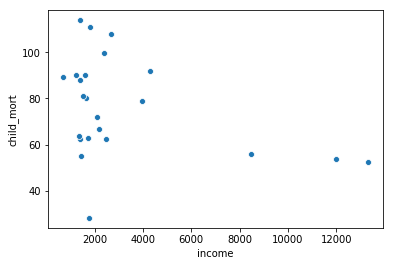

In [74]:
'''
Let's visualise the clusters here. We don't see the countries properly clustered here. 
Hence we don't create cluster because that would give a skewed result.
'''

datp=dat8[dat8['ClusterID']==0]
sns.scatterplot(x='income',y='child_mort',data=datp)

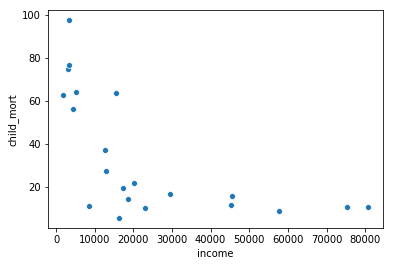

In [76]:
datp=dat8[dat8['ClusterID']==1]
sns.scatterplot(x='income',y='child_mort',data=datp)

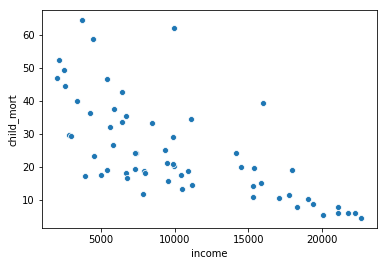

In [77]:
datp=dat8[dat8['ClusterID']==2]
sns.scatterplot(x='income',y='child_mort',data=datp)

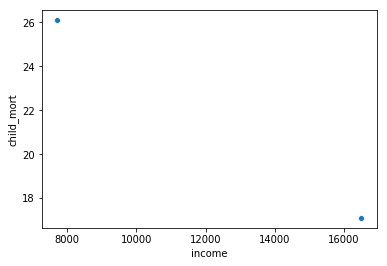

In [79]:
datp=dat8[dat8['ClusterID']==4]
sns.scatterplot(x='income',y='child_mort',data=datp)

### Final result : We use the clusters formed during K-means clustering to find the countries that we require since Hierarchical clustering is not showing proper clusters here. For K-means part, we got Cluster 1 and 4 might be the ones which has a proper need of aid. Cluster 2 countries might also improve with aid.

### Note 1

In this solution K-means and Hierarchical don't produce identical insights.This would depend on the way the principal components and the final number of clusters are chosen. It would be perfectly fine if both provide identical insights in any other case

###  Note 2
For outliers that I removed before clustering took place, I can take any approach to include them in the final list of countries that I'd focus on. Either reassign them to the clusters that were formed and see if Cluster 2 and Cluster 4 have any more countries or use one variable from some of the main indicators to bin the entire 167 countries. Like if I take GDPP, keep the bin limits as 0-1700, 1700-3200,3200-6000,6000-13000 and >13000. The bin limits are decided on the basis of the approximate gdpp means that we got for the 5 clusters. Categorise all the countries from the original dataset within these limits and then take all the countries less than 1700 as the cutoff.Similarly, proceed for the 2nd variable.Any other logically thought out approach also works.

## To get the final list of countries to be focused on.

In [56]:
fin = pd.read_csv('Country-data.csv')

# Converting exports,imports and health spending percentages to absolute values.

fin['exports'] = fin['exports']*fin['gdpp']/100
fin['imports'] = fin['imports']*fin['gdpp']/100
fin['health'] = fin['health']*fin['gdpp']/100

In [57]:
fin.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [58]:
# Let's use the binning with gdpp first to see the list of countries which might be important.
# The upper limit that we got from the clustering process was 1700.
# let's filter the complete dataset with 1700 as the cut-off limit for gdpp.

fin2=fin[fin['gdpp']<=1700]
fin2.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.3000,41.9174,248.297,1610,9.440,56.2,5.82,553
12,Bangladesh,49.4,121.2800,26.6816,165.244,2440,7.140,70.4,2.33,758
17,Benin,111.0,180.4040,31.0780,281.976,1820,0.885,61.8,5.36,758
25,Burkina Faso,116.0,110.4000,38.7550,170.200,1430,6.810,57.9,5.87,575
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.300,57.7,6.26,231


In [59]:
len(fin2)

48

In [60]:
# So we got 48 countries here. We can create further sub categories by taking another good clustering indicator. 
# Let's use the describe function to see how the variables are aligned now.
fin2.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,84.808333,242.988282,53.166544,389.688794,2209.229167,8.849688,60.789583,4.552500,847.583333
std,37.864382,208.411190,36.338142,306.718665,1134.428833,5.849055,7.282776,1.382764,384.444824
min,17.200000,1.076920,12.821200,0.651092,609.000000,0.885000,32.100000,1.270000,231.000000
25%,61.350000,101.630250,31.079500,175.909500,1390.000000,4.080000,57.175000,3.465000,551.500000
50%,82.050000,150.912000,44.388600,280.956000,1900.000000,8.215000,61.250000,4.875000,758.000000
75%,108.250000,388.087500,60.501250,450.765000,2857.500000,12.150000,66.125000,5.370000,1205.000000
max,208.000000,943.200000,190.710000,1279.550000,4490.000000,23.600000,73.100000,7.490000,1630.000000


In [61]:
# From the clustering process we got child_mortality to be at least 76 for the most downtrodden cluster. 
# Let's see how many countries lie within that range

len(fin2[fin2['child_mort']>=76])

28

In [62]:
# Ok so we got 28 countries now. We can stop here or take one more indicator and find the final list.
# Here we are taking income as the next one, where around 3200 was the income mean of the downtrodden cluster.

fin3=fin2[fin2['child_mort']>=76]
fin4=fin3[fin3['income']<3200]
len(fin4)

23

In [63]:
# The final list of countries 

fin4

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.3000,41.9174,248.297,1610,9.440,56.2,5.82,553
17,Benin,111.0,180.4040,31.0780,281.976,1820,0.885,61.8,5.36,758
25,Burkina Faso,116.0,110.4000,38.7550,170.200,1430,6.810,57.9,5.87,575
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.300,57.7,6.26,231
28,Cameroon,108.0,290.8200,67.2030,353.700,2660,1.910,57.3,5.11,1310
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.010,47.5,5.21,446
32,Chad,150.0,330.0960,40.6341,390.195,1930,6.390,56.5,6.59,897
36,Comoros,88.2,126.8850,34.6819,397.573,1410,3.870,65.9,4.75,769
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.800,57.5,6.54,334
40,Cote d'Ivoire,111.0,617.3200,64.6600,528.260,2690,5.390,56.3,5.27,1220


#### Final Conclusion and Remarks: 
Major focus should be given to the countries mentioned above.